In [299]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import ta as ta

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None  # default='warn'

## Data Wrangling

In [300]:
def get_data():
    """
    Downloads and wrangles data for BlackSwan 2.0 VIX modeling. 
  
    Combines the two index datasets and creates a 
    new DataFrame (df) that contains the target feature (Trading Days with 3 
    STDV shifts based on a rolling window)
  
    :input: vix  => CBOE VIX Historical Data
    :input: gspc => GSPC S&P 500 index with matching start date to VIX
  
    :return: df  => cominbation VIX/GSPC Dataset with Target Classifier 
    """
  
    ############### Getting Data ##################
  
    vix = (data.DataReader('^VIX', 
                           "yahoo", 
                           start='1990-1-02', 
                           end='2019-5-31')
           .drop(columns = ['Volume', 'Adj Close']))
  
    gspc = data.DataReader('^GSPC', 
                           "yahoo", 
                           start='1990-1-02',
                           end='2019-5-31')
    
    treasury = (pd.read_csv('USTREASURY-YIELD.csv')
                .sort_values(by = 'Date')
                .drop(columns=['1 MO', '2 MO', '20 YR']))
    
    fred = pd.read_csv('FRED-PERMIT.csv')
    
    ism = pd.read_csv('ismvsgdp.csv').drop(index = [0,1])
    
    lag = pd.read_csv('USLgI.csv')
  
    ############### Wrangling Data #################
    
    # Rename the Columns
    vix.columns      = ['vix_high', 'vix_low', 'vix_open', 'vix_close']
    gspc.columns     = ['gspc_high', 'gspc_low', 'gspc_open',
                        'gspc_close','gspc_volume','gspc_adj_close']
  
    # Join the VIX and GSPC
    df = vix.join(gspc)
  
    # Pull Date columns out of the index
    df = df.reset_index()
    
    # Merge DF with the Treasury Data on the Date Feature
    # Date needs to be converted to Datetime format to match df['Date']
    treasury['Date'] = pd.to_datetime(treasury['Date'],
                                      infer_datetime_format=True)
    
    df = pd.merge(df, treasury, how='inner', on='Date')
    
    
    
    # A new feature is needed to act as a key for the following features
    df['y/m'] = df['Date'].map(lambda x: x.strftime('%Y-%m'))
    
    # Line up the Date column with the new key for the FRED Data
    fred = fred[fred['Date'] > '1989-12-01'].sort_values(by='Date')
    fred['Date'] = pd.to_datetime(fred['Date'], infer_datetime_format=True)
    fred['Date'] =  fred['Date'].map(lambda x: x.strftime('%Y-%m'))
    
    # Line up the Date column iwth the new key for the ISM/GDP Data
    ism = ism[ism['ticker'] > '1989-12-01'].sort_values(by='ticker')
    ism['ticker'] = pd.to_datetime(ism['ticker'], infer_datetime_format=True)
    ism['ticker'] =  ism['ticker'].map(lambda x: x.strftime('%Y-%m'))
    # Add most recent ISM data
    ism = (ism.append(pd.DataFrame([['2019-04', 52.8, np.nan]
                                   ,['2019-05', 52.1,np.nan]]
                                   ,columns=ism.columns))
           .reset_index()
           .drop(columns='index'))
    #Add most recent GDP Value
    ism['GDP CURY Index'].iloc[351] = 5.0
    # Fill in Quarterly GDP values
    ism = ism.fillna(method='ffill').fillna(method='bfill')
    
    # Wrangle the date column for the Lagging Index Dataframe
    lag['Date'] = pd.to_datetime(lag['Date'], format='%b-%y')
    #Create a pivot point around 2019 to accomodate the 2-digit year format
    for i in np.arange(len(lag)):
        if lag['Date'][i].year > 2019:
            lag['Date'][i] = lag['Date'][i].replace(year=lag['Date'][i].year-100)
        else:
            pass
    # Map to the y/m key format
    lag['Date'] =  lag['Date'].map(lambda x: x.strftime('%Y-%m'))
    #Slice the dataframe to relevant time period
    lag = lag[lag['Date'] > '1989-12']
    

    # Create New Columns with a single iteration using list comprehension
    f  = []
    m  = []
    g  = []
    ll = []
    lg = []

    for i in np.arange(len(df)):
        # Merge the New Private Housing Units Authorized by Building Permits (FRED)
        f.append(float(fred.loc[fred['Date'] == df['y/m'][i]]['Value']
                       .values
                       .tolist()[0]))
        
        # Merge the ISM NAPMPMI Index
        m.append(float(ism.loc[ism['ticker'] == df['y/m'][i]]['NAPMPMI Index']
                       .values
                       .tolist()[0]))
        
        # Merge the GDP CURY Index
        g.append(float(ism.loc[ism['ticker'] == df['y/m'][i]]['GDP CURY Index']
                       .values
                       .tolist()[0]))
        
            # Merge the Lagging Index Level Column
        ll.append(float(lag.loc[lag['Date'] == df['y/m'][i]]['Level']
                        .values
                        .tolist()[0]))
        
        # Merge the Lagging Index Growth Column
        lg.append(float(lag.loc[lag['Date'] == df['y/m'][i]]['Growth']
                        .values
                        .tolist()[0]))
    
    df['lag_index_level'] = ll
    df['lag_index_growth'] = lg
    df['fred'] = f
    df['ism'] = m
    df['gdp_cury'] = g
    
  
    ############### Momemntum Feature Engineering ################
  
    # Awesome Oscillator
    df['mom_ao']=ta.momentum.ao(df['gspc_high'],
                                df['gspc_low'],
                                s=5,len=34,
                                fillna=True)

    # Money Flow Index
    df['mom_mf']=ta.momentum.money_flow_index(df['gspc_high'],
                                              df['gspc_low'],
                                              df['gspc_close'],
                                              df['gspc_volume'],
                                              n=14,fillna=True)
  
    # Relative Strength Index
    df['mom_rsi'] = ta.momentum.rsi(df['gspc_close'],
                                    n=14,
                                    fillna=True)
  
    # Stochasitc Oscillator
    df['mom_stoch']=ta.momentum.stoch(df['gspc_high'],
                                      df['gspc_low'],
                                      df['gspc_close'],
                                      n=14,
                                      fillna=True)
  
    # Stochasitc Signal
    df['mom_st_sig']=ta.momentum.stoch_signal(df['gspc_high'],
                                              df['gspc_low'],
                                              df['gspc_close'],
                                              n=14,
                                              d_n=3,
                                              fillna=True)
  
    # True Strength Indicator
    df['mom_tsi'] = ta.momentum.tsi(df['gspc_close'],
                                    r=25,
                                    s=13,
                                    fillna=True)
  
    # Ultimate Oscillator
    df['mom_uo'] = ta.momentum.uo(df['gspc_high'],
                                  df['gspc_low'],
                                  df['gspc_close'], 
                                  s=7, 
                                  m=14, 
                                  len=28, 
                                  ws=4.0, 
                                  wm=2.0, 
                                  wl=1.0,
                                  fillna=True)
  
    # Williams %R
    df['mom_wr']=ta.momentum.wr(df['gspc_high'],
                                df['gspc_low'],
                                df['gspc_close'],
                                lbp=14,fillna=True)
  
    ############### Volume Feature Engineering ####################
  
    # Accumulation/Distribution Index
    df['vol_adi']=ta.volume.acc_dist_index(df['gspc_high'],
                                           df['gspc_low'],
                                           df['gspc_close'],
                                           df['gspc_volume'],
                                           fillna=True)
  
    # Chaikin Money Flow
    df['vol_cmf'] = ta.volume.chaikin_money_flow(df['gspc_high'],
                                                 df['gspc_low'],
                                                 df['gspc_close'],
                                                 df['gspc_volume'],
                                                 n=20,fillna=True)
  
    # Ease of Movement
    df['vol_eom'] = ta.volume.ease_of_movement(df['gspc_high'],
                                               df['gspc_low'],
                                               df['gspc_close'],
                                               df['gspc_volume'],
                                               n=20,fillna=True)
  
    # Force Index
    df['vol_fm'] = ta.volume.force_index(df['gspc_close'],
                                         df['gspc_volume'],
                                         n=2,fillna=True)
  
    # Negative Volume Index
    df['vol_nvi'] = ta.volume.negative_volume_index(df['gspc_close'],
                                                    df['gspc_volume'],
                                                    fillna=True)
  
    # On-Balance Volume
    df['vol_obv'] = ta.volume.on_balance_volume(df['gspc_close'],
                                                df['gspc_volume'],
                                                fillna=True)
  
    # Volume-Price Trend
    df['vol_vpt'] = ta.volume.volume_price_trend(df['gspc_close'],
                                                 df['gspc_volume'],
                                                 fillna=True)
    
    ############### Volatility Feature Engineering
    
    #Average True Range
    df['atr_low'] = ta.volatility.average_true_range(df['gspc_high'],
                                                     df['gspc_low'],
                                                     df['gspc_close'],
                                                     n=23)
    
    df['atr_high'] = ta.volatility.average_true_range(df['gspc_high'],
                                                      df['gspc_low'],
                                                      df['gspc_close'],
                                                      n=37)
  
    ############### Target Creation #################
  
    # Determine daily market movement between Close and Close
    df['vix_move']  = (1 - df['vix_close']
                       .shift(1)/df['vix_close'])
  
    df['gspc_move'] = (1 - df['gspc_close']
                       .shift(1)/df['gspc_close'])
  
  
  
    ##### 30 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_30'] = (df['vix_move']
                            .rolling(30).std())
  
    df['gspc_rolling_30'] = (df['gspc_move']
                             .rolling(30).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_30'] = np.where(abs(df['gspc_move'])
                                 >=3*df['gspc_rolling_30'],1,0)
  
    df['2.5sd_move_30'] = np.where(abs(df['gspc_move'])
                                   >=2.5*df['gspc_rolling_30'],1,0)
  
    df['2sd_move_30'] = np.where(abs(df['gspc_move'])
                                 >=2*df['gspc_rolling_30'],1,0)
  
    df['1.5sd_move_30'] = np.where(abs(df['gspc_move'])
                                   >=1.5*df['gspc_rolling_30'],1,0)
  
  
    ##### 90 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_90'] = (df['vix_move']
                            .rolling(90).std())
  
    df['gspc_rolling_90'] = (df['gspc_move']
                             .rolling(90).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_90'] = np.where(abs(df['gspc_move'])
                                 >=3*df['gspc_rolling_90'],1,0)
  
    df['2.5sd_move_90'] = np.where(abs(df['gspc_move'])
                                   >=2.5*df['gspc_rolling_90'],1,0)
  
    df['2sd_move_90'] = np.where(abs(df['gspc_move'])
                                 >=2*df['gspc_rolling_90'],1,0)
  
    df['1.5sd_move_90'] = np.where(abs(df['gspc_move'])
                                   >=1.5*df['gspc_rolling_90'],1,0)
  
  
    ##### 120 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_120'] = (df['vix_move']
                            .rolling(120).std())
  
    df['gspc_rolling_120'] = (df['gspc_move']
                             .rolling(120).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_120'] = np.where(abs(df['gspc_move'])
                                  >=3*df['gspc_rolling_120'],1,0)
  
    df['2.5sd_move_120'] = np.where(abs(df['gspc_move'])
                                    >=2.5*df['gspc_rolling_120'],1,0)
  
    df['2sd_move_120'] = np.where(abs(df['gspc_move'])
                                  >=2*df['gspc_rolling_120'],1,0)
  
    df['1.5sd_move_120'] = np.where(abs(df['gspc_move'])
                                    >=1.5*df['gspc_rolling_120'],1,0)
  
  
    ##### 252 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_252'] = (df['vix_move']
                            .rolling(252).std())
  
    df['gspc_rolling_252'] = (df['gspc_move']
                             .rolling(252).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_252'] = np.where(abs(df['gspc_move'])
                                  >=3*df['gspc_rolling_252'],1,0)
  
    df['2.5sd_move_252'] = np.where(abs(df['gspc_move'])
                                    >=2.5*df['gspc_rolling_252'],1,0)
  
    df['2sd_move_252'] = np.where(abs(df['gspc_move'])
                                  >=2*df['gspc_rolling_252'],1,0)
  
    df['1.5sd_move_252'] = np.where(abs(df['gspc_move'])
                                    >=1.5*df['gspc_rolling_252'],1,0)
  
  
    ############## Handling Null Values ##################
    
    # Interpolating the Null Values for 30yr Treasury Bonds
    df['30 YR'] = (df['30 YR'].interpolate(method='spline',
                                           order=4))
    
    # Drop the rest
    #df = df.dropna()
  
    return df
  

In [ ]:
df = get_data()

In [ ]:
print(df.shape,'\n', df.isnull().sum(),'\n',
      df.info(),'\n', df.describe(),'\n\n')
df.head()

In [173]:
def crash_dates():

    """
    Rough outline of the 2008 Housing Crisis Crash
    """
    start_date = '2008-09-10'
    end_date = '2009-03-05'
    crash = (df[df['Date'] > start_date])
    crash = (crash[crash['Date'] < end_date])
  
    return crash

In [175]:
# A look at how many instances of ~~~ > [threshold STDEV] ~~~~ days are in the dataset

for target in targets:
    print('{}: {} '.format(target+' targets:     ',df[target].value_counts()[1]))

1.5sd_move_30 targets:     : 969 
2sd_move_30 targets:     : 393 
2.5sd_move_30 targets:     : 145 
3sd_move_30 targets:     : 49 
1.5sd_move_90 targets:     : 941 
2sd_move_90 targets:     : 406 
2.5sd_move_90 targets:     : 184 
3sd_move_90 targets:     : 91 
1.5sd_move_120 targets:     : 914 
2sd_move_120 targets:     : 408 
2.5sd_move_120 targets:     : 192 
3sd_move_120 targets:     : 88 
1.5sd_move_252 targets:     : 906 
2sd_move_252 targets:     : 406 
2.5sd_move_252 targets:     : 208 
3sd_move_252 targets:     : 100 


## Target and Features

>**Targets** I have created a number of target columns in order to create a really rough gradient descent for rolling Standard Deviations of day-day GSPC closes. 

>**Leakage** These are features to be dropped as they are deemed to be leaky or noisy

>**features** This is the resulting dataframe to be inserted into a model. 


In [12]:
targets  = ['1.5sd_move_30','2sd_move_30','2.5sd_move_30','3sd_move_30',
            '1.5sd_move_90','2sd_move_90','2.5sd_move_90','3sd_move_90',
            '1.5sd_move_120','2sd_move_120','2.5sd_move_120','3sd_move_120',
            '1.5sd_move_252','2sd_move_252','2.5sd_move_252','3sd_move_252']

leakage  = ['Date']

features  = (df.drop(columns = targets)
            .drop(columns = leakage)
            .columns)

## Baseline Modeling

In [13]:
# Baseline Modeling Imports

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix

In [14]:
def split(target, features=features):
    """
    Temporal Train Test Split. Holdout is most recent data.  
    """
    
    X = df[features]
    y = df[target]
    
    X_train = X[:int(len(X.index)*.7)]
    X_test= X[int(len(X.index)*.7):len(X.index)]
    y_train=y[:int(len(y.index)*.7)]
    y_test=y[int(len(y.index)*.7):len(y.index)]
    
    return X_train, X_test, y_train, y_test
    

In [156]:
def results(y_test=y_test, y_pred=y_pred):

    print(' F1 Score: ', f1_score(y_test, y_pred),'\n',
          'Precision: ', precision_score(y_test, y_pred), '\n',
          '   Recall: ', recall_score(y_test, y_pred), '\n',
          '  ROC_AUC: ', roc_auc_score(y_test, y_pred), '\n\n')
        
    return pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns = ['predicted_0', 'predicted_1'],
                        index = ['actaul_0', 'actual_1'])

In [155]:
def log_reg(X_train=X_train, y_train=y_train):
  
    LR=LogisticRegression(solver='lbfgs')
    LR.fit(X_train,y_train)
  
    y_pred =LR.predict(X_test)   
  
    return y_pred

def gauss(X_train=X_train, y_train=y_train):

    GNB = GaussianNB()
    GNB.fit(X_train,y_train)
   
    y_pred=GNB.predict(X_test)

    
    return y_pred

In [170]:
"""
Something is broken here. Not really worth the time at the moment. 
"""


# def check_models():
  
#     above_50 = []
    
#     print('\n\n Logisitic Regression:\n')
#     for target in targets:
#         X_train, X_test, y_train, y_test = split(target)
#         print(target+":\n")
#         y_pred = log_reg()
#         results()
#         #if precision_score(y_test, y_pred) > .5:
#             #above_50.append('Logistic Regression: ', target)
#         #else:
#             #pass
#     print('\n\n Gaussian Naive Bayes:\n')
    
#     for target in targets:
#         X_train, X_test, y_train, y_test = split(target)
#         print(target+":\n")
#         y_pred = gauss()
#         results()
#         if precision_score(y_test, y_pred) > .5:
#             above_50.append('Gaussian Naive Bayes: ', target)
#         else:
#             pass
            
#     return above_50

'\nSomething is broken here. Not really worth the time at the moment. \n'

## ARIMA Modeling

In [ ]:
#ARIMA Modeling Imports

from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

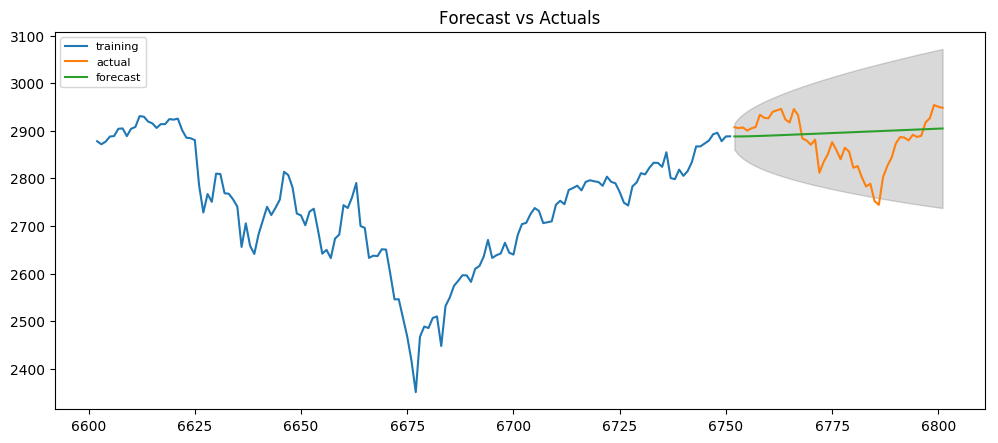

In [ ]:

train = df.gspc_close[1:-50]
test = df.gspc_close[-50:]
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(50, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-150:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Playground

This area is for testing. 

In [167]:
vix = (data.DataReader('^VIX', 
                           "yahoo", 
                           start='1990-1-02', 
                           end='2019-5-31')
           .drop(columns = ['Volume', 'Adj Close'])
      .reset_index())

In [168]:
vix['y/m'] = vix['Date'].map(lambda x: x.strftime('%Y-%m'))

In [6]:
margin = pd.read_csv('month_over_month_margin_balances.csv')

In [286]:
lag = pd.read_csv('USLgI.csv')

In [287]:
lag['Date'] = pd.to_datetime(lag['Date'], format='%b-%y')

for i in np.arange(len(lag)):
    if lag['Date'][i].year > 2019:
        lag['Date'][i] = lag['Date'][i].replace(year=lag['Date'][i].year-100)
    else:
        pass
    
lag['Date'] =  lag['Date'].map(lambda x: x.strftime('%Y-%m'))

lag = lag[lag['Date'] > '1989-12']

/anaconda3/envs/vix/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [289]:
ll = []
lg = []

for i in np.arange(len(df)):
    # Merge the Lagging Index Level Column
    ll.append(float(lag.loc[lag['Date'] == df['y/m'][i]]['Level']
                   .values
                   .tolist()[0]))
        
        # Merge the Lagging Index Growth Column
    lg.append(float(lag.loc[lag['Date'] == df['y/m'][i]]['Growth']
                   .values
                   .tolist()[0]))
        

In [290]:
df['lag_index_level'] = ll
df['lag_index_growth'] = lg

In [292]:
lag

,Date,Level,Growth
504,1990-01,102.5,0.5
505,1990-02,103.0,1.0
506,1990-03,102.5,-0.3
507,1990-04,102.6,-0.3
508,1990-05,102.7,-0.4
509,1990-06,102.9,0.1
510,1990-07,103.1,0.3
511,1990-08,102.4,-0.8
512,1990-09,102.7,-0.2
513,1990-10,103.3,0.9


In [ ]:
import datetime
dd = datetime.datetime.strptime(date,'%y%m%d')
if dd.year > 2005:
   dd = dd.replace(year=dd.year-100)

In [261]:
lag['Date'].map(lambda x: x.strptime(x,"%b-%y"))

AttributeError: 'str' object has no attribute 'strptime'